## Necessary imports

In [2]:
import math, random, sys
sys.path.append("/workspace/GTM")
sys.path.append('/workspace/icml18-jtnn_original')

from gtm import GTMEstimator

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader
from torch.autograd import Variable
from tqdm import tqdm
import numpy as np
from CGRtools import smiles
from optparse import OptionParser
from collections import deque
from IPython.display import clear_output
import matplotlib.pyplot as plt

from jtnn import *
import rdkit
from rdkit import Chem
    
lg = rdkit.RDLogger.logger() 
lg.setLevel(rdkit.RDLogger.CRITICAL)

In [4]:
def show_molecules(smiles, props, target):
    row = math.ceil(len(smiles)/3)
    column = 3

    plt.figure(figsize=(18, 6*row))
    for i, mol in enumerate(smiles):
        position = 1 + i
        img = Chem.Draw.MolToImage(Chem.MolFromSmiles(mol))

        ax = plt.subplot(row, column, position)
        title = mol + "\n"
        for key, value in props.items():
            title += "{}: {:.4f}\n".format(key, value[i])
            
        if target is not None:
            mse = value
            for k, (key, value) in enumerate(props.items()):
                title += "MSE value for {}: {:.4f}\n".format(key, abs(value[i] - target[k]))
        ax.set_title(title)
        ax.axis("off")
        ax.imshow(img)

    plt.show()

## Requiered functions and constants

In [5]:
batch_size = 256

In [6]:
class load_mol():
    def __init__(self, data, target):
        self.data, self.target = data, target

## Data

In [4]:
vocab_path = "./data/qdb9/prunned/vocab.txt"
vocab = [x.strip("\r\n ") for x in open(vocab_path)] 
vocab = Vocab(vocab)

In [7]:
test_path = "./data/qdb9/prunned/qdb9/test_smiles.txt"
test_prop_path = "./data/qdb9/prunned/qdb9/test_lumo.txt"
test_data = PropDataset(test_path, test_prop_path)

train_path = "./data/qdb9/prunned/qdb9/train_smiles.txt"
train_prop_path = "./data/qdb9/prunned/qdb9/train_lumo.txt"
train_data = PropDataset(train_path, train_prop_path)

test = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=lambda x:x, drop_last=False)
train = DataLoader(train_data, batch_size=batch_size, shuffle=False, collate_fn=lambda x:x, drop_last=False)

In [45]:
tick_params_m = {
    'which':'both',
    'bottom':False,  
    'left':False,
    'right':False,
    'top':False,
    'labelleft':False,
    'labelright':False,
    'labeltop':False,
    'labelbottom':False
}

tick_params = {
    'which':'both',
    'bottom':False,  
    'left':False,
    'right':False,
    'top':False,
    'labelleft':False,
    'labelright':False,
    'labeltop':False,
    'labelbottom':True,
}

In [51]:
def show_molecules(smiles, props, filename=None):
    row = math.ceil(len(smiles)/5)
    column = 5

    plt.figure(figsize=(18, 3*row))
    for i, mol in enumerate(smiles):
        position = 1 + i
        img = Chem.Draw.MolToImage(Chem.MolFromSmiles(mol))

        ax = plt.subplot(row, column, position)
        title = mol + "\n" + str(props[i])
        ax.set_xlabel(title)
        if i == 0:
            ax.spines["right"].set_linestyle(":")
            ax.tick_params(**tick_params_m) # labels along the bottom edge are off
        else:
            ax.spines["top"].set_linestyle("none")
            ax.spines["bottom"].set_linestyle("none")
            ax.spines["left"].set_linestyle("none")
            ax.spines["right"].set_linestyle("none")
            ax.tick_params(**tick_params_m) # labels along the bottom edge are off
        ax.imshow(img)

    if filename is not None:
        plt.savefig(filename)
    plt.show()

## Molecule visualisation

In [57]:
mols = ['C1COC(O1)=O',
'OCC1(CC1NC(C2[NH2+]CCCC2)=O)C',
'O=C(NC1C(C1)(C)C[NH3+])C',
'C1C(O)CC(C([O-])=O)(CC1)C',
'C1C(C(=O)C)CCO1',
'O=C(C)C(OC)C#N',
'C1CCCCC1C(C#N)C',
'OCC1C(C)C1',
'c1cc(ccc1O)CNC(=O)C2(CCCCC2)C',
'O1c2c(c(c(cc2)C)OC)CCCC1',
'C1CCC(C1)OC(C)CC',
'C1CC1(C(c2ccccc2N)=O)OCC',
'O=S(=O)(C)C1C(C1)(C)COC']

homo = [-6.805753,
        -6.639012,
        -6.864084,
        -6.611206,
        -7.562531,
        -8.061135,
        -6.861677,
        -6.248363,
        -5.754284,
        -6.830246,
        -5.721571,
        -6.862993,
        -7.986135]

filename = "mol_m_3_mol_1"

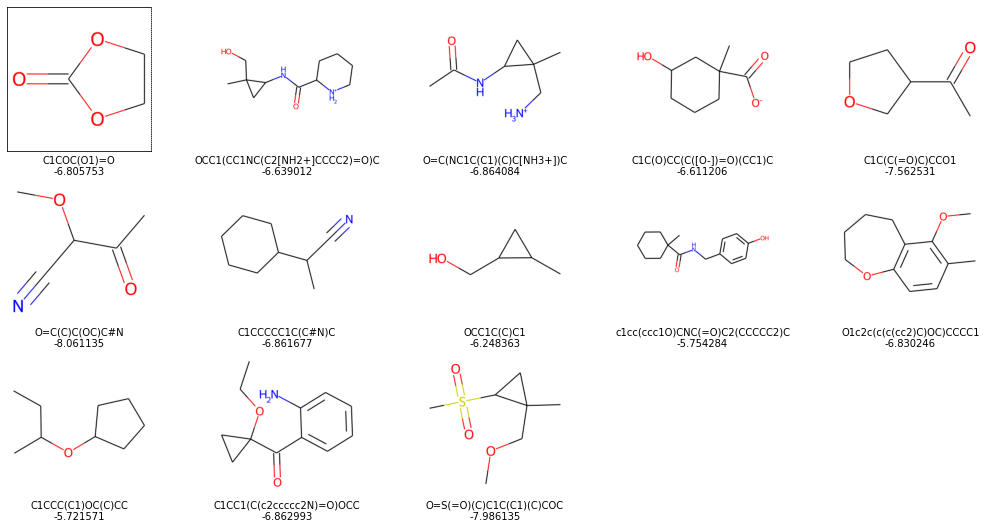

In [58]:
show_molecules(mols, homo, filename)

In [59]:
mols = ['C1=CC(C)C=CC(=O)C1',
        'C1CC(CCC1)(C(NC(C)c2ccccc2)=O)C',
        'C1C(CC1S(=O)(=O)C)OCC',
        'c1ccccc1C(=O)NC2CC2(C)C(O)O',
        'C1CCCC1(OCC)C=O',
        'c1cc(ccc1)C(NC(c2c(C)ncs2)=O)C',
        'c1ccc(cc1C)NC(=O)C(C)C#N',
        'c1cc(ccc1)C(C)NC(=O)c2sc(nc2)OCC',
        'c1ccccc1CN(C(=O)c2c(C)scn2)C',
        'C(O)C(C)NC(=O)c1sc(nc1)C',
        'c1cc(ccc1NC(=O)C2CCOC2C)O',
        'C12CC(C(C1)C)C2O',
        'OCC1(CC(CC1)NC(=O)C)C',
        'O=C(C1C(CO)(C1)C)[O-]',
        'OCC(C)NC(=O)C1CCCCC1C',
        'C1CC(C(=O)[O-])C(C)CC1',
        'C1CC1(C(O)C)NC(=O)c2ccccc2',
        'C(O)C(C)NC(=O)c1ncc(s1)C',
        'C1CN(CCN1C(=O)C)C2C(C)(C2)C[NH3+]']

homo = [-5.841408,
        -6.793117,
        -5.880566,
        -6.714777,
        -6.175159,
        -7.107976,
        -6.003467,
        -6.000722,
        -6.782050,
        -6.446191,
        -7.336546,
        -6.374263,
        -6.922675,
        -6.755608,
        -7.185734,
        -6.276589,
        -6.610229,
        -5.747948,
        -6.266463]
filename = "mol_n_3_mol_1"

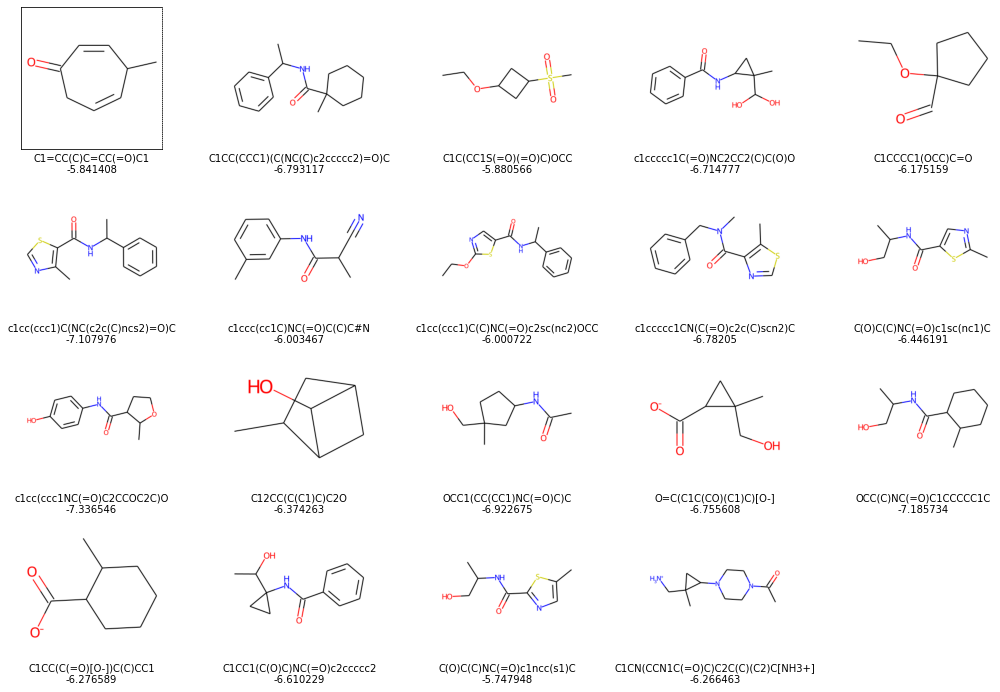

In [60]:
show_molecules(mols, homo, filename)